# Caterpiller OEE and BIQ Analysis for Lines 6 & 7


### Data management

prepare data to be analyzed by:
1. split data into respective lines
2. add columns to see setups
    + add column to see order number on 7


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_data = pd.read_csv("OEE_BIQ.csv")


In [4]:
data_nadrop = raw_data.dropna(subset=["Operation","Production Order", "Operator","Construction","Shift"])

Columns that are require non-null values had null values dropped. 

Rows Dropped: <font  color="red"> 138 </font>

In [6]:
line6 = data_nadrop[data_nadrop['Operation'].apply(lambda x: x.split(" ")[1]) == '6']
line7 = data_nadrop[data_nadrop['Operation'].apply(lambda x: x.split(" ")[1]) == '7']
welder = data_nadrop[(data_nadrop['Operation'].apply(lambda x: x.split(" ")[0]) == '151')]

Cleaning up the data a little bit by correcting misspelled words

In [8]:
line6_operations = {
    "LE/FW": ("LE", "fill"),
    "STW": ("stw", "Stw"),
    "EXT": ("-EXT", "fill")
}

line7_operations = {
    "STW/UW": ("STW", "UW"),
    "LE/FW": ("LE", "FW"),
}

def correct_operation(word, corrections,line):
    for correct, incorrect in corrections.items():
        if word in incorrect:
            return correct
    return word

line6.loc[:,"Operation"] = line6["Operation"].apply(lambda x: correct_operation(x.split(" ")[3], line6_operations,6))
line7.loc[:,"Operation"] = line7["Operation"].apply(lambda x: correct_operation(x.split(" ")[3], line7_operations,7))

Now to clean one off PO's to get rid of outlier/bad data

In [10]:
count7 = line7["Production Order"].value_counts()
unique7 = count7[count7 == 1]
line7_clean = line7[~line7["Production Order"].isin(list(unique7.keys()))]

In [11]:
count6 = line6["Production Order"].value_counts()
unique6 = count6[count6 == 1]
line6_clean = line6[~line6["Production Order"].isin(list(unique6.keys()))]

In [12]:
line6_constructions = ["3/4\" XT-6ES","1\" XT-3ES","3/4\" XT-3ES","1\" XT-6ES"]
line7_constructions = ["1/2\" XT-3ES","3/8\" XT-3ES","3/8\" XT-6ES","5/8\" XT-3ES","1/2\" XT-6ES"]

line6_clean = line6_clean[line6_clean["Construction"].isin(line6_constructions)]
line7_clean = line7_clean[line7_clean["Construction"].isin(line7_constructions)]

In [13]:
line6_clean["Construction"][line6_clean["OEE Filter"] == "OEE"]

2          1" XT-3ES
9        3/4" XT-3ES
14       3/4" XT-6ES
17       3/4" XT-6ES
26       3/4" XT-6ES
            ...     
29977    3/4" XT-6ES
29984    3/4" XT-6ES
29985    3/4" XT-6ES
29987    3/4" XT-6ES
29993      1" XT-3ES
Name: Construction, Length: 6869, dtype: object

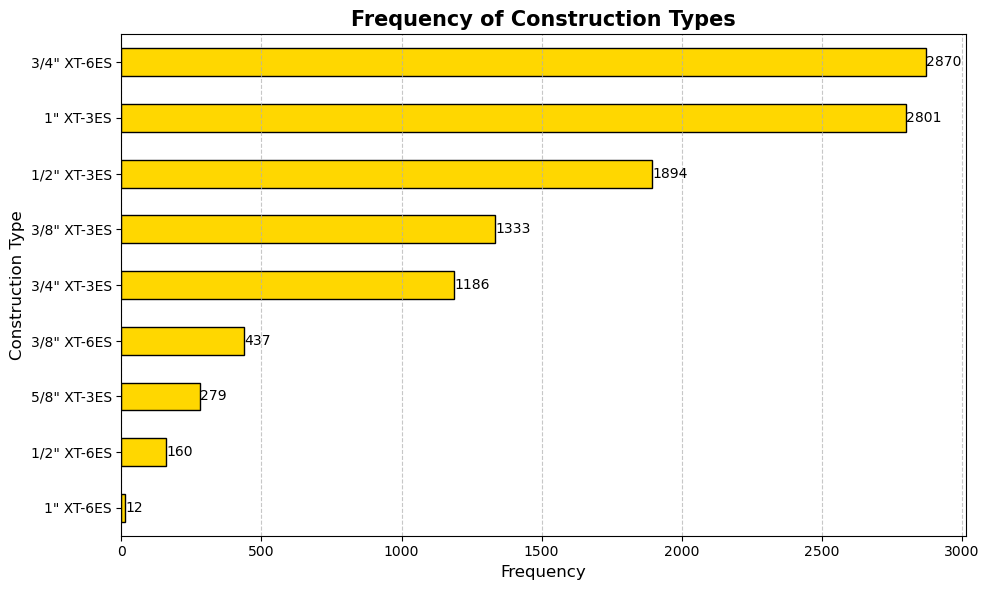

In [14]:
#
orders_by_size = pd.concat([line6_clean["Construction"][line6_clean["OEE Filter"] == "OEE"],
                            line7_clean["Construction"][line7_clean["OEE Filter"] == "OEE"]])
orders_by_size_counts = orders_by_size.value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
bars = orders_by_size_counts.plot(kind="barh", color="gold", edgecolor="black")
plt.ylabel("Construction Type", fontsize=12)
plt.xlabel("Frequency", fontsize=12)
plt.title("Frequency of Construction Types", fontsize=15, fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.7)
for index, value in enumerate(orders_by_size_counts):
    plt.text(value + 1, index, str(value), va="center", color="black", fontsize=10)
plt.tight_layout()
plt.show()

Line 6 has a higher ratio of BIQ to OEE entries showing that Line 6 has either substantially more issues or line 7 is under reporting

In [16]:
line6_OEE,line6_BIQ = line6_clean[line6_clean["OEE Filter"] == "OEE"],line6_clean[line6_clean["OEE Filter"] != "OEE"]
line7_OEE,line7_BIQ = line7_clean[line7_clean["OEE Filter"] == "OEE"],line7_clean[line7_clean["OEE Filter"] != "OEE"]

print("line|   OEE  | BIQ")
print("-"*22)
print(f"6   |  {len(line6_OEE)}  | {len(line6_BIQ)}")
print(f"7   |  {len(line7_OEE)}  | {len(line7_BIQ)}")

line|   OEE  | BIQ
----------------------
6   |  6869  | 12828
7   |  4103  | 5496


This Graph shows that 1" xt3 and 3/4" xt3 have the highest rate of BIQ entries. 1" xt6 is not really ran on the line, but 3/4" xt6 is ran on the line in the highest volume but has 64% fewer BIQ entries.

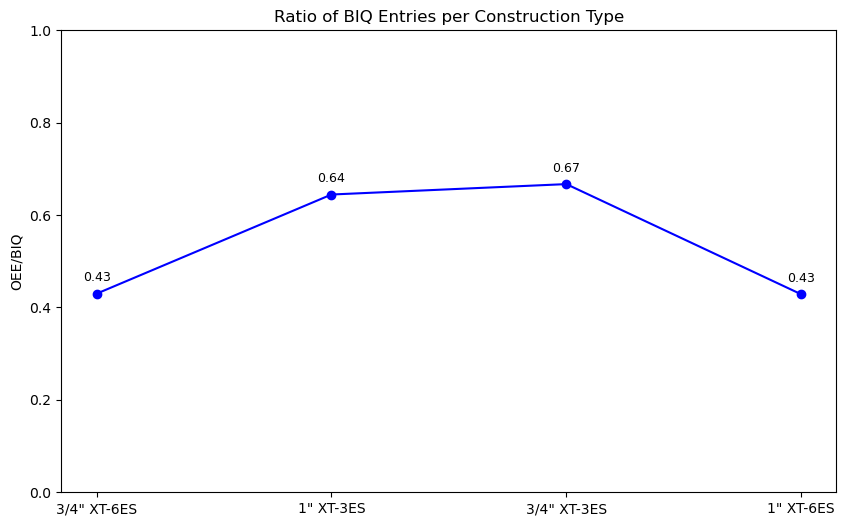

In [18]:
x = line6_OEE["Construction"].value_counts()/ line6_BIQ["Construction"].value_counts()
labels = list(x.index)

plt.figure(figsize=(10, 6))
line = plt.plot(labels, x, marker='o', linestyle='-', color='b')
plt.ylim(0,1)
plt.ylabel('OEE/BIQ')
plt.title('Ratio of BIQ Entries per Construction Type')
for i, value in enumerate(x):
    plt.text(labels[i], value+.02, str(round(value, 2)), color="black", fontsize=9, ha='center', va='bottom')
plt.show()

## Setup Time Breakdowns
Status: **rough**

In [20]:
line7_clean["Line"] = 7
line7_clean = line7_clean.sort_values(by="ID")

In [21]:
line7_clean = line7_clean.drop(columns=["Created By"])

In [22]:
line7_clean["Wire Change"] = 0

In [23]:
for x in line7_clean["Defect Description"].value_counts().keys():
    if "setup" in x.lower():
        print(x)

Helping with Setup
Spiral Winder Setup
Setup


In [24]:
count=0
weird=[]
spiral_winder = line7_clean[line7_clean["Operation"] == "SW"]
for (i, row), (j, next_row) in zip(spiral_winder.iterrows(), spiral_winder.iloc[1:].iterrows()):
    if row["OEE Filter"] != "OEE" and "setup" in str(row["Defect Description"]).lower() and row["Operation"] == "SW":
        weird.append((i,spiral_winder.index.get_loc(i)))



In [25]:
count = 0
po = line7_clean["Production Order"].iloc[0]
for i, row in spiral_winder.iterrows():
    if row["OEE Filter"] != "OEE" and  "setup" in str(row["Defect Description"]).lower() and row["Operation"] == "SW" and po != row["Production Order"]:
        count += 1
        spiral_winder.at[i,"Wire Change"] = count
        po = row["Production Order"]
    else:
        spiral_winder.at[i,"Wire Change"] = count

In [26]:
wire = 0
po = spiral_winder["Production Order"].iloc[0]
order = 1

spiral_winder = spiral_winder.sort_values(by=["Wire Change","Production Order"])

for i, row in spiral_winder.iterrows():
    if row["Wire Change"] == wire:
        if row["Production Order"] == po:
            spiral_winder.at[i,"Order"] = order
        else:
            order += 1
            po = row["Production Order"]
            spiral_winder.at[i,"Order"] = order
    else:
        wire += 1
        order = 1
        spiral_winder.at[i,"Order"] = order
spiral_winder[["Production Order","Operation","Order","Wire Change"]]      

,Production Order,Operation,Order,Wire Change
23,5.001911e+09,SW,1.0,0
62,5.001911e+09,SW,1.0,0
63,5.001911e+09,SW,1.0,0
85,5.001911e+09,SW,1.0,0
154,5.001911e+09,SW,2.0,0
...,...,...,...,...
29942,5.002467e+09,SW,2.0,30
29953,5.002467e+09,SW,2.0,30
29874,5.002467e+09,SW,3.0,30
29911,5.002467e+09,SW,3.0,30


pd.set_option('display.float_format','{:.1f}'.format)
for i in weird:
    print(spiral_winder.iloc[i[1]-10:i[1]+10][["Order","Production Order","Defect Description","Wire Change"]])
    print("******************************************************************")